# IMPORT LIBRARY

In [ ]:
# import library
!pip install google-play-scraper
import csv
import requests
import re
import pandas as pd
from io import StringIO
from google_play_scraper import reviews_all, Sort

# LOAD DATA SCRAPING

In [ ]:
# load data scraping
scrapreview = reviews_all(
    'com.mobile.legends',
    lang = 'id',
    country = 'id',
    sort = Sort.MOST_RELEVANT,
    count = 10000
)

# DISPLAY RESULT SCRAPING

In [ ]:
# converting the scraped results into a DataFrame
df = pd.DataFrame(scrapreview)

# displaying the first 5 rows of the dataset
print("\nData after scraping (first 5 rows):")
print(df.head())

# checking for NaN values in each column
print("\nNumber of NaN values in each column:")
print(df.isnull().sum())

# dropping rows that contain NaN values
df.dropna(inplace=True)
print("\nNumber of NaN values after cleaning:")
print(df.isnull().sum())


Data after scraping (first 5 rows):
                               reviewId         userName  \
0  96ae8328-008b-47fe-96c9-3d5db197e3eb  Pengguna Google   
1  7f51ce49-52fb-4f99-aff4-a3582da2c63f  Pengguna Google   
2  d223728c-8d0b-4ba9-aa13-a4372924f858  Pengguna Google   
3  25fb7f54-3922-468a-8350-9d5064587e08  Pengguna Google   
4  3a4b6aff-694e-4e58-a1b3-39446f8f095c  Pengguna Google   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0  [Sengaja rate 5] gw udah muak ama moonton. KEB...      5           4336   
1  klo main selalu dapat tim beban, meskipun kita...      1           6636   
2  Terlalu banyak yg d upgrade 

# CLEANING TEXT SCRAPING

In [ ]:
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# function to clean the text
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # remove hashtags
    text = re.sub(r'RT[\s]', '', text)         # remove "RT" retweet text
    text = re.sub(r"http\S+", '', text)        # remove links
    text = re.sub(r'[0-9]+', '', text)         # remove numbers
    text = re.sub(r'[^\w\s]', '', text)        # remove non-alphanumeric characters
    text = text.replace('\n', ' ')             # replace newlines with space
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.strip(' ')                     # remove leading and trailing spaces
    return text

# convert all characters to lowercase
def casefoldingText(text):
    return text.lower()

# tokenize the text into words
def tokenizingText(text):
    return word_tokenize(text)

# remove stopwords from the tokenized text
def filteringText(text):
    stopword_list = set(stopwords.words('indonesian'))
    stopword_list.update(stopwords.words('english'))
    stopword_list.update([
        'iya','yaa','gak','nya','na','sih','ku','di','ga','ya',
        'gaa','loh','kah','woi','woii','woy'
    ])
    return [word for word in text if word not in stopword_list]

# convert words to their root form (stemming)
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# convert list of words back to sentence
def toSentence(list_words):
    return ' '.join(list_words)

# define a dictionary of slang words and their replacements
slangwords = {
    "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih",
    "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal"
}

# function to replace slang words with standard words
def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords[word.lower()] if word.lower() in slangwords else word for word in words]
    return ' '.join(fixed_words)

# download necessary NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# create a copy of the original DataFrame
clean_df = df.copy()

# step-by-step text preprocessing pipeline
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# POSITIVE NEGATIVE SENTIMENT

In [ ]:
import requests
import csv
from io import StringIO

# load the positive lexicon data from GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# send HTTP request to get the CSV file from GitHub

if response.status_code == 200:
    # if the request is successful
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # read the response text as a CSV file

    for row in reader:
        # iterate over each row in the CSV
        lexicon_positive[row[0]] = int(row[1])
        # add positive words and their scores into the lexicon_positive dictionary
else:
    print("Failed to fetch positive lexicon data")

# load the negative lexicon data from GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# send HTTP request to get the CSV file from GitHub

if response.status_code == 200:
    # if the request is successful
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # read the response text as a CSV file

    for row in reader:
        # iterate over each row in the CSV
        lexicon_negative[row[0]] = int(row[1])
        # add negative words and their scores into the lexicon_negative dictionary
else:
    print("Failed to fetch negative lexicon data")

# function to determine the sentiment polarity of a tweet/text
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    # initialize sentiment score to 0

    for word in text:
        # iterate through each word in the text
        if word in lexicon_positive:
            score += lexicon_positive[word]
            # add the positive score if the word is in the positive lexicon

    for word in text:
        # iterate through each word in the text again
        if word in lexicon_negative:
            score += lexicon_negative[word]
            # add the negative score if the word is in the negative lexicon

    polarity = ''
    # initialize the polarity variable

    if score >= 0:
        polarity = 'positive'
        # if the score is greater than or equal to 0, sentiment is positive
    elif score < 0:
        polarity = 'negative'
        # if the score is less than 0, sentiment is negative

    return score, polarity
    # return the sentiment score and polarity

# apply the sentiment analysis function to the preprocessed text
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['sentiment'] = results[1]

# display sentiment distribution
print(clean_df['sentiment'].value_counts())

# save to CSV
clean_df.to_csv("data_scraping_MLBB.csv", index=False)
print("Data successfully saved as data_lexicon_labeled.csv")

sentiment
negative    6397
positive    3110
Name: count, dtype: int64
Data successfully saved as data_lexicon_labeled.csv


# PLOTTING SENTIMENT

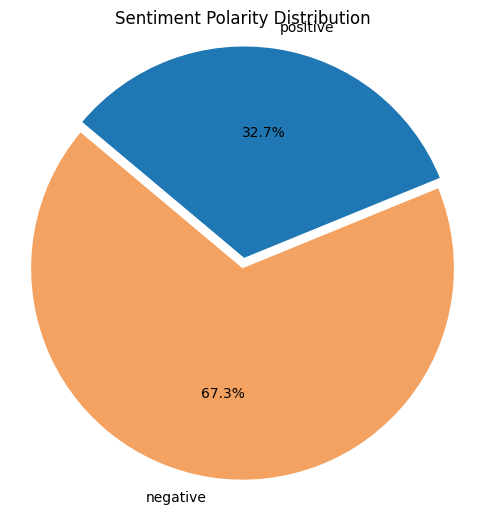

In [ ]:
import matplotlib.pyplot as plt

# calculate sentiment polarity distribution
polarity_counts = clean_df['sentiment'].value_counts()
labels = polarity_counts.index
sizes = polarity_counts.values
colors = ['#f4a261', '#1f77b4', '#2ca02c']  # Customize colors if needed
explode = [0.05 if label == 'positive' else 0 for label in labels]  # Highlight the positive slice

# plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors[:len(labels)],
    startangle=140,
    explode=explode
)
plt.title('Sentiment Polarity Distribution')
plt.axis('equal')  # ensures the pie chart is a circle
plt.show()

# WORDSCLOUDS SENTIMENT

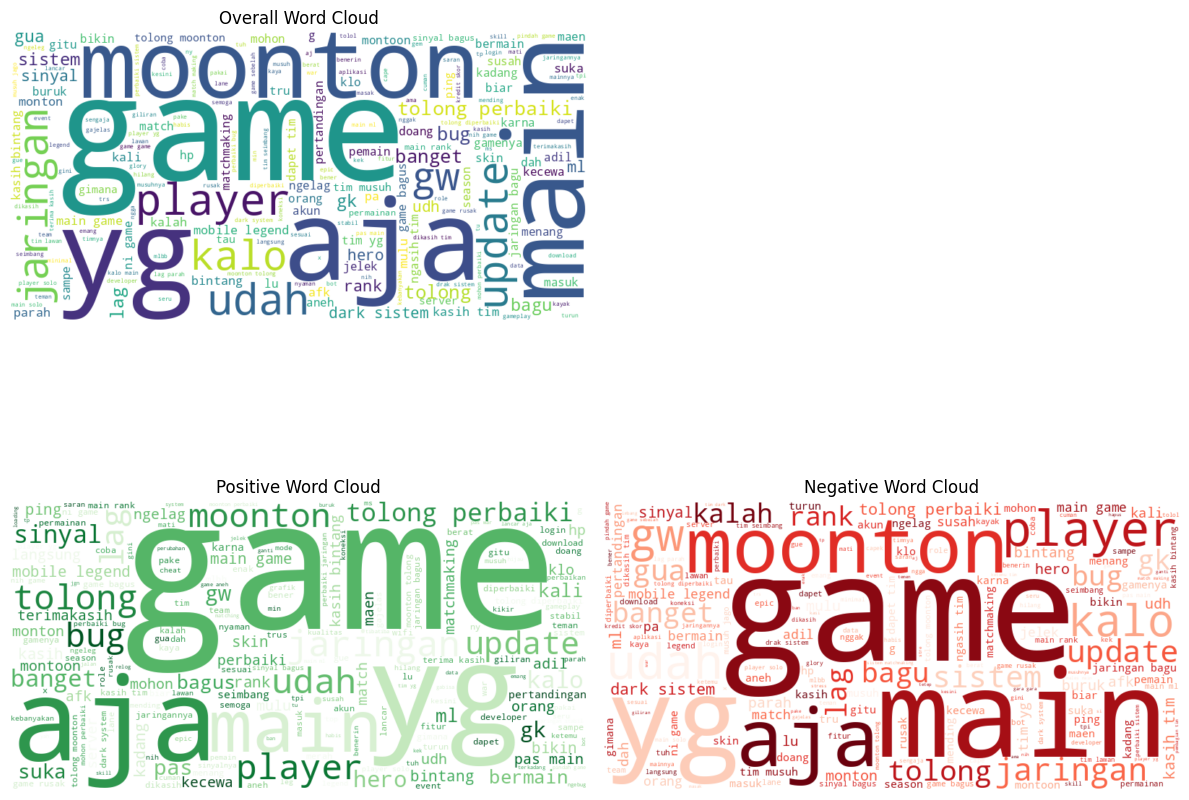

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# combine all words by sentiment category
all_text = ' '.join([' '.join(text) for text in clean_df['text_stopword']])
positive_text = ' '.join([' '.join(text) for text in clean_df[clean_df['sentiment'] == 'positive']['text_stopword']])
negative_text = ' '.join([' '.join(text) for text in clean_df[clean_df['sentiment'] == 'negative']['text_stopword']])

# generate WordClouds
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(all_text)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# display WordClouds in a 2x2 layout
plt.figure(figsize=(12, 10))

# overall WordCloud
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Overall Word Cloud')

# positive WordCloud
plt.subplot(2, 2, 3)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Word Cloud')

# negative WordCloud
plt.subplot(2, 2, 4)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Word Cloud')

plt.tight_layout()
plt.show()

# INSIGHT

Notebook python ini berisikan langkah-langkah koding dimulai dari import, data scraping hingga wordclouds sentiment. Saya mengambil sampel terkait penilaian aplikasi Mobile Legends pada playstore dengan minimal 3000 data. Lalu setelah data terkumpulkan saya membersihkan teks terlebih dahulu untuk bisa melakukan analisis sentimen terkait penilaian aplikasi Mobile Legends.